In [2]:
from functools import partial
from jax import random as jr, lax, vmap, nn
from pymdp.jax.envs import GraphEnv

import networkx as nx
import jax.numpy as jnp

In [4]:
def generate_connected_clusters(cluster_size=2, connections=2):
    edges = []
    connecting_node = 0
    while connecting_node < connections * cluster_size:
        edges += [(connecting_node, a) for a in range(connecting_node + 1, connecting_node + cluster_size + 1)]
        connecting_node = len(edges)
    graph = nx.Graph()
    graph.add_edges_from(edges)
    return graph, {
        "locations": [
            (f"hallway {i}" if len(list(graph.neighbors(loc))) > 1 else f"room {i}")
            for i, loc in enumerate(graph.nodes)
        ]
    }

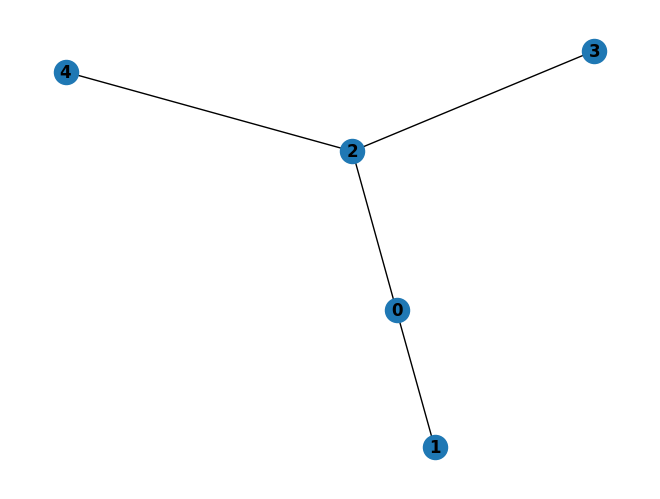

In [5]:
graph, _ = generate_connected_clusters(cluster_size=2, connections=2)
nx.draw(graph, with_labels=True, font_weight="bold")

In [6]:
key = jr.PRNGKey(0)
env = GraphEnv(graph, 3, 0)

2024-06-11 12:10:10.915385: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [8]:
batch_size = 1
keys = jr.split(key, batch_size + 1)
key = keys[-1]

action = jnp.broadcast_to(jnp.array([4, 0]), (batch_size, 2))
print(action.shape)

_keys = keys[:batch_size]
print(jnp.shape(_keys))
obs = env.step(_keys, action)
print(obs)

(1, 2)
(1, 2)
([Array([0], dtype=int32), Array([0], dtype=int32)], GraphEnv(
  params={
    'A':
    [f32[1,5,5], f32[1,2,5,6]],
    'B':
    [f32[1,5,5,5], f32[1,6,6,1]],
    'D':
    [f32[1,5], f32[1,6]]
  },
  states=[[i32[1], i32[1]], [i32[1], i32[1]]],
  dependencies={'A': [[0], [0, 1]], 'B': [[0], [1]]}
))


In [10]:
from pymdp.jax.agent import Agent

A = [a for a in env.params["A"]]
B = [b for b in env.params["B"]]
A_dependencies = env.dependencies["A"]
B_dependencies = env.dependencies["B"]

C = [jnp.zeros(a.shape[:2]) for a in A]
C[1] = C[1].at[1].set(1.0)

D = [jnp.ones(b.shape[:2]) for b in B]

agent = Agent(A, B, C, D, None, None, None, A_dependencies=A_dependencies, B_dependencies=B_dependencies)

In [14]:
# add a time dimension
qs = [jnp.broadcast_to(d, (1,) + d.shape) for d in D]

print([s.shape for s in qs])
q_pi, nefe = agent.infer_policies(qs)

[(1, 1, 5), (1, 1, 6)]


In [9]:
batch_keys = jr.split(key, batch_size + 1)
_keys = keys[:batch_size]
key = keys[-1]
actions = agent.sample_action(q_pi, rng_key=_keys)

In [10]:
print(actions)

[[1 0]]


In [11]:
batch_keys = jr.split(key, batch_size + 1)
_keys = keys[:batch_size]
key = keys[-1]
obs, env = env.step(_keys, action)

In [18]:
print(obs)
# add time dim
obs_b = [jnp.broadcast_to(o, (1,) + o.shape) for o in obs]

print([s.shape for s in qs])
print(actions.shape)
prior, _ = agent.update_empirical_prior(actions, qs)

agent.infer_states(obs_b, None, prior, None)

[Array([0], dtype=int32), Array([0], dtype=int32)]
[(1, 1, 5), (1, 1, 6)]
(1, 2)


[Array([[[0.16048184, 0.35807264, 0.16048184, 0.16048184, 0.16048184]]],      dtype=float32),
 Array([[[3.0379263e-03, 2.4523251e-06, 3.0379263e-03, 3.0379263e-03,
          3.0379263e-03, 9.8784572e-01]]], dtype=float32)]

In [14]:
import mctx
import chex
from typing import Optional
from mctx._src.policies import _mask_invalid_actions
from mctx._src import action_selection
from mctx._src import base
from mctx._src import qtransforms
from mctx._src import search
from mctx._src import seq_halving

def gumbel_si_policy(
    params: base.Params,
    rng_key: chex.PRNGKey,
    root: base.RootFnOutput,
    recurrent_fn: base.RecurrentFn,
    num_simulations: int,
    invalid_actions: Optional[chex.Array] = None,
    max_depth: Optional[int] = None,
    loop_fn: base.LoopFn = lax.fori_loop,
    *,
    qtransform: base.QTransform = qtransforms.qtransform_completed_by_mix_value,
    max_num_considered_actions: int = 16,
    gumbel_scale: chex.Numeric = 1.,
) -> base.PolicyOutput[action_selection.GumbelMuZeroExtraData]:
  """Runs Gumbel MuZero search and returns the `PolicyOutput`.

  This policy implements Full Gumbel MuZero from
  "Policy improvement by planning with Gumbel".
  https://openreview.net/forum?id=bERaNdoegnO

  At the root of the search tree, actions are selected by Sequential Halving
  with Gumbel. At non-root nodes (aka interior nodes), actions are selected by
  the Full Gumbel MuZero deterministic action selection.

  In the shape descriptions, `B` denotes the batch dimension.

  Args:
    params: params to be forwarded to root and recurrent functions.
    rng_key: random number generator state, the key is consumed.
    root: a `(prior_logits, value, embedding)` `RootFnOutput`. The
      `prior_logits` are from a policy network. The shapes are
      `([B, num_actions], [B], [B, ...])`, respectively.
    recurrent_fn: a callable to be called on the leaf nodes and unvisited
      actions retrieved by the simulation step, which takes as args
      `(params, rng_key, action, embedding)` and returns a `RecurrentFnOutput`
      and the new state embedding. The `rng_key` argument is consumed.
    num_simulations: the number of simulations.
    invalid_actions: a mask with invalid actions. Invalid actions
      have ones, valid actions have zeros in the mask. Shape `[B, num_actions]`.
    max_depth: maximum search tree depth allowed during simulation.
    loop_fn: Function used to run the simulations. It may be required to pass
      hk.fori_loop if using this function inside a Haiku module.
    qtransform: function to obtain completed Q-values for a node.
    max_num_considered_actions: the maximum number of actions expanded at the
      root node. A smaller number of actions will be expanded if the number of
      valid actions is smaller.
    gumbel_scale: scale for the Gumbel noise. Evalution on perfect-information
      games can use gumbel_scale=0.0.

  Returns:
    `PolicyOutput` containing the proposed action, action_weights and the used
    search tree.
  """
  # Masking invalid actions.
  root = root.replace(
      prior_logits=_mask_invalid_actions(root.prior_logits, invalid_actions)
  )

  # Generating Gumbel.
  rng_key, gumbel_rng = jr.split(rng_key)
  gumbel = gumbel_scale * jr.gumbel(
      gumbel_rng, shape=root.prior_logits.shape, dtype=root.prior_logits.dtype
    )

  # Searching.
  extra_data = action_selection.GumbelMuZeroExtraData(root_gumbel=gumbel)
  search_tree = search.search(
      params=params,
      rng_key=rng_key,
      root=root,
      recurrent_fn=recurrent_fn,
      root_action_selection_fn=partial(
          action_selection.gumbel_muzero_root_action_selection,
          num_simulations=num_simulations,
          max_num_considered_actions=max_num_considered_actions,
          qtransform=qtransform,
      ),
      interior_action_selection_fn=partial(
          action_selection.gumbel_muzero_interior_action_selection,
          qtransform=qtransform,
      ),
      num_simulations=num_simulations,
      max_depth=max_depth,
      invalid_actions=invalid_actions,
      extra_data=extra_data,
      loop_fn=loop_fn)
  summary = search_tree.summary()

  # Acting with the best action from the most visited actions.
  # The "best" action has the highest `gumbel + logits + q`.
  # Inside the minibatch, the considered_visit can be different on states with
  # a smaller number of valid actions.
  considered_visit = jnp.max(summary.visit_counts, axis=-1, keepdims=True)
  # The completed_qvalues include imputed values for unvisited actions.
  completed_qvalues = vmap(qtransform, in_axes=[0, None])(  # pytype: disable=wrong-arg-types  # numpy-scalars  # pylint: disable=line-too-long
      search_tree, search_tree.ROOT_INDEX
    )
  to_argmax = seq_halving.score_considered(
      considered_visit,
      gumbel,
      root.prior_logits,
      completed_qvalues,
      summary.visit_counts
    )
  action = action_selection.masked_argmax(to_argmax, invalid_actions)

  # Producing action_weights usable to train the policy network.
  completed_search_logits = _mask_invalid_actions(
      root.prior_logits + completed_qvalues, invalid_actions)
  action_weights = nn.softmax(completed_search_logits)
  return base.PolicyOutput(
      action=action,
      action_weights=action_weights,
      search_tree=search_tree)


#step, embedding = recurrent_fn(params, rng_key, action, embedding)

def recurrent_fn(params, rng_key, action, embedding):
  pass

def _make_aif_recurrent_fn(policies):
  """Returns a recurrent_fn for a determistic bandit."""

  def recurrent_fn(agent, rng_key, action, embedding):
    qs = embedding
    # For the bandit, the reward will be non-zero only at the root.
    reward = jnp.where(embedding == 0,
                       qvalues[jnp.arange(action.shape[0]), action],
                       0.0)
    
        G = []
    # get exp info gain and utility for each action
    rollout = lambda act: agent.update_empirical_prior(qs, act)
    qs_next_pi = vmap(rollout)(policies)
    qo_next_pi = jtu.tree_map( lambda a, q: a @ q, agent.A, qs_next)
    neg_efe = exp_utility(qo_next_pi) + exp_info_gain(qs_next_pi, qo_next_pi)

    # recursively branch the policy + outcome tree
    for p in policies:
       G_next_p = 0

       for o in possible_outcomes:
           prob = qo_next[o]
           qs_next_posterior = agent.infer_states(qs_next, o)

           G_next = expand(qs_next_posterior ...)
           G_next_p += G_next * prob
       G_next_p = q_pi[p] * G_next_p
       G[p] += G_next_p
       return G
    
    # use fake discount set to 1. everywhere
    discount = jnp.ones_like(neg_efe)
    recurrent_fn_output = mctx.RecurrentFnOutput(
        reward=neg_efe,
        discount=discount,
        prior_logits=jnp.log(agent.E),
        value=jnp.zeros_like(neg_efe))
    next_embedding = embedding + 1
    return recurrent_fn_output, next_embedding

  return recurrent_fn

# policy_output = gumber_si_policy(
#     agents,
#     rng_key,
#     root,
#     recurrent_fn,
#     num_simulations=32,
#     tree=None,
#     max_nodes=48
# )
# tree = policy_output.search_tree

NameError: name 'efe_policy' is not defined

In [ ]:
def stochastic_si_policy(
    params: chex.ArrayTree,
    rng_key: chex.PRNGKey,
    root: base.RootFnOutput,
    decision_recurrent_fn: base.DecisionRecurrentFn,
    chance_recurrent_fn: base.ChanceRecurrentFn,
    num_simulations: int,
    invalid_actions: Optional[chex.Array] = None,
    max_depth: Optional[int] = None,
    loop_fn: base.LoopFn = jax.lax.fori_loop,
    *,
    qtransform: base.QTransform = qtransforms.qtransform_by_parent_and_siblings,
    dirichlet_fraction: chex.Numeric = 0.25,
    dirichlet_alpha: chex.Numeric = 0.3,
    pb_c_init: chex.Numeric = 1.25,
    pb_c_base: chex.Numeric = 19652,
    temperature: chex.Numeric = 1.0) -> base.PolicyOutput[None]:
  """Runs Stochastic MuZero search.

  Implements search as described in the Stochastic MuZero paper:
    (https://openreview.net/forum?id=X6D9bAHhBQ1).

  In the shape descriptions, `B` denotes the batch dimension.
  Args:
    params: params to be forwarded to root and recurrent functions.
    rng_key: random number generator state, the key is consumed.
    root: a `(prior_logits, value, embedding)` `RootFnOutput`. The
      `prior_logits` are from a policy network. The shapes are `([B,
      num_actions], [B], [B, ...])`, respectively.
    decision_recurrent_fn: a callable to be called on the leaf decision nodes
      and unvisited actions retrieved by the simulation step, which takes as
      args `(params, rng_key, action, state_embedding)` and returns a
      `(DecisionRecurrentFnOutput, afterstate_embedding)`.
    chance_recurrent_fn:  a callable to be called on the leaf chance nodes and
      unvisited actions retrieved by the simulation step, which takes as args
      `(params, rng_key, chance_outcome, afterstate_embedding)` and returns a
      `(ChanceRecurrentFnOutput, state_embedding)`.
    num_simulations: the number of simulations.
    invalid_actions: a mask with invalid actions. Invalid actions have ones,
      valid actions have zeros in the mask. Shape `[B, num_actions]`.
    max_depth: maximum search tree depth allowed during simulation.
    loop_fn: Function used to run the simulations. It may be required to pass
      hk.fori_loop if using this function inside a Haiku module.
    qtransform: function to obtain completed Q-values for a node.
    dirichlet_fraction: float from 0 to 1 interpolating between using only the
      prior policy or just the Dirichlet noise.
    dirichlet_alpha: concentration parameter to parametrize the Dirichlet
      distribution.
    pb_c_init: constant c_1 in the PUCT formula.
    pb_c_base: constant c_2 in the PUCT formula.
    temperature: temperature for acting proportionally to `visit_counts**(1 /
      temperature)`.

  Returns:
    `PolicyOutput` containing the proposed action, action_weights and the used
    search tree.
  """

  num_actions = root.prior_logits.shape[-1]

  rng_key, dirichlet_rng_key, search_rng_key = jax.random.split(rng_key, 3)

  # Adding Dirichlet noise.
  noisy_logits = _get_logits_from_probs(
      _add_dirichlet_noise(
          dirichlet_rng_key,
          jax.nn.softmax(root.prior_logits),
          dirichlet_fraction=dirichlet_fraction,
          dirichlet_alpha=dirichlet_alpha))

  root = root.replace(
      prior_logits=_mask_invalid_actions(noisy_logits, invalid_actions))

  # construct a dummy afterstate embedding
  batch_size = jax.tree_util.tree_leaves(root.embedding)[0].shape[0]
  dummy_action = jnp.zeros([batch_size], dtype=jnp.int32)
  dummy_output, dummy_afterstate_embedding = decision_recurrent_fn(
      params, rng_key, dummy_action, root.embedding)
  num_chance_outcomes = dummy_output.chance_logits.shape[-1]

  root = root.replace(
      # pad action logits with num_chance_outcomes so dim is A + C
      prior_logits=jnp.concatenate([
          root.prior_logits,
          jnp.full([batch_size, num_chance_outcomes], fill_value=-jnp.inf)
      ], axis=-1),
      # replace embedding with wrapper.
      embedding=base.StochasticRecurrentState(
          state_embedding=root.embedding,
          afterstate_embedding=dummy_afterstate_embedding,
          is_decision_node=jnp.ones([batch_size], dtype=bool)))

  # Stochastic MuZero Change: We need to be able to tell if different nodes are
  # decision or chance. This is accomplished by imposing a special structure
  # on the embeddings stored in each node. Each embedding is an instance of
  # StochasticRecurrentState which maintains this information.
  recurrent_fn = _make_stochastic_recurrent_fn(
      decision_node_fn=decision_recurrent_fn,
      chance_node_fn=chance_recurrent_fn,
      num_actions=num_actions,
      num_chance_outcomes=num_chance_outcomes,
  )

  # Running the search.

  interior_decision_node_selection_fn = functools.partial(
      action_selection.muzero_action_selection,
      pb_c_base=pb_c_base,
      pb_c_init=pb_c_init,
      qtransform=qtransform)

  interior_action_selection_fn = _make_stochastic_action_selection_fn(
      interior_decision_node_selection_fn, num_actions)

  root_action_selection_fn = functools.partial(
      interior_action_selection_fn, depth=0)

  search_tree = search.search(
      params=params,
      rng_key=search_rng_key,
      root=root,
      recurrent_fn=recurrent_fn,
      root_action_selection_fn=root_action_selection_fn,
      interior_action_selection_fn=interior_action_selection_fn,
      num_simulations=num_simulations,
      max_depth=max_depth,
      invalid_actions=invalid_actions,
      loop_fn=loop_fn)

  # Sampling the proposed action proportionally to the visit counts.
  search_tree = _mask_tree(search_tree, num_actions, 'decision')
  summary = search_tree.summary()
  action_weights = summary.visit_probs
  action_logits = _apply_temperature(
      _get_logits_from_probs(action_weights), temperature)
  action = jax.random.categorical(rng_key, action_logits)
  return base.PolicyOutput(
      action=action, action_weights=action_weights, search_tree=search_tree)


In [ ]:
# extract the subtree corresponding to the chosen action
tree = mctx.get_subtree(tree, action)

# go to next environment state

batch_keys = jr.split(key, batch_size + 1)
_keys = keys[:batch_size]
key = keys[-1]
obs, env = env.step(_keys, actions)

# reset the search tree where the environment has terminated
tree = mctx.reset_search_tree(tree, env.terminated)

# new search with subtree
# (max_nodes has no effect when a tree is passed) 
policy_ouput = efe_policy(
    params,
    rng_key,
    root,
    recurrent_fn,
    num_simulations=32,
    tree=tree
)
